In [6]:
# Importing Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

In [8]:
"""
Load the prepared train/test datasets created in DataPreparation.ipynb.

- pd.read_csv(): loads processed feature matrices and labels.
- squeeze(): converts a single-column label DataFrame into a 1D Series (preferred by scikit-learn).
"""
X_train = pd.read_csv("processed/X_train.csv")
X_test  = pd.read_csv("processed/X_test.csv")

y_train = pd.read_csv("processed/y_train.csv").squeeze()
y_test  = pd.read_csv("processed/y_test.csv").squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6499, 116), (1625, 116), (6499,), (1625,))

In [10]:
"""
Train a Random Forest classifier.

Key parameters:
- n_estimators: number of trees in the forest.
- random_state: ensures reproducible training.
- n_jobs=-1: uses all CPU cores (faster training).
"""
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_model


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [12]:
"""
Generate test predictions and probability scores.

We treat poisonous ('p') as the positive class.
"""
y_pred_rf = rf_model.predict(X_test)

proba_rf = rf_model.predict_proba(X_test)
p_index_rf = list(rf_model.classes_).index("p")
y_score_rf = proba_rf[:, p_index_rf]

y_pred_rf[:10], y_score_rf[:10]


(array(['p', 'p', 'e', 'p', 'p', 'e', 'e', 'e', 'e', 'p'], dtype=object),
 array([1., 1., 0., 1., 1., 0., 0., 0., 0., 1.]))

In [14]:
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_rf


1.0

In [16]:
print(classification_report(y_test, y_pred_rf, target_names=["Edible (e)", "Poisonous (p)"]))


               precision    recall  f1-score   support

   Edible (e)       1.00      1.00      1.00       842
Poisonous (p)       1.00      1.00      1.00       783

     accuracy                           1.00      1625
    macro avg       1.00      1.00      1.00      1625
 weighted avg       1.00      1.00      1.00      1625



In [18]:
"""
Confusion matrix (rows=actual, columns=predicted).

Most safety-critical error: poisonous predicted edible (FN).
"""
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["e", "p"])

cm_rf_df = pd.DataFrame(
    cm_rf,
    index=["Actual_e", "Actual_p"],
    columns=["Pred_e", "Pred_p"]
)
cm_rf_df


,Pred_e,Pred_p
Actual_e,842,0
Actual_p,0,783


In [20]:
"""
Metrics table (poisonous 'p' as positive class).
"""
roc_auc_rf = roc_auc_score((y_test == "p").astype(int), y_score_rf)

precision_rf = precision_score(y_test, y_pred_rf, pos_label="p")
recall_rf    = recall_score(y_test, y_pred_rf, pos_label="p")
f1_rf        = f1_score(y_test, y_pred_rf, pos_label="p")

ap_rf = average_precision_score((y_test == "p").astype(int), y_score_rf)

metrics_rf = pd.DataFrame({
    "METRIC": ["ACCURACY", "PRECISION (p)", "RECALL (p)", "F1-SCORE (p)", "ROC-AUC", "AP"],
    "VALUE":  [acc_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf, ap_rf]
})
metrics_rf["VALUE"] = metrics_rf["VALUE"].round(4)
metrics_rf


,METRIC,VALUE
0,ACCURACY,1.0
1,PRECISION (p),1.0
2,RECALL (p),1.0
3,F1-SCORE (p),1.0
4,ROC-AUC,1.0
5,AP,1.0


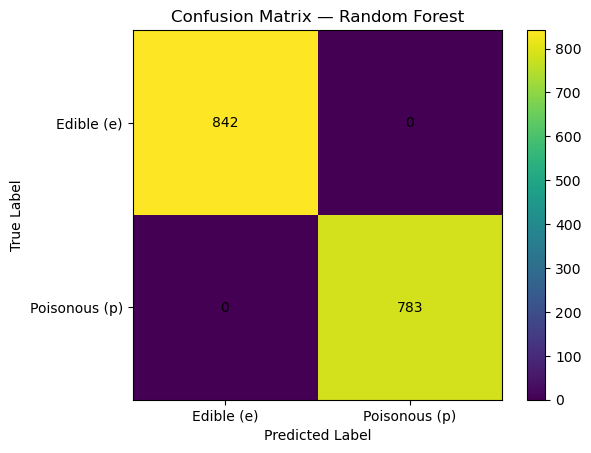

In [28]:
# Confusion Matrix Heatmap 
fig, ax = plt.subplots()
im = ax.imshow(cm_rf, interpolation="nearest")
ax.set_title("Confusion Matrix — Random Forest")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Edible (e)", "Poisonous (p)"])
ax.set_yticklabels(["Edible (e)", "Poisonous (p)"])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        ax.text(j, i, cm_rf[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax)
plt.show()

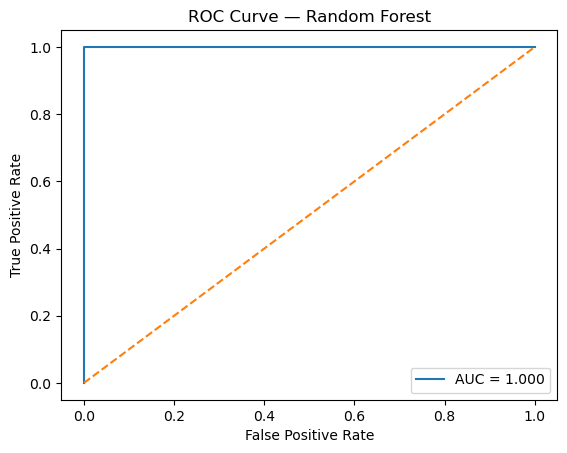

In [24]:
#ROC Curve 

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf, pos_label="p")

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve — Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

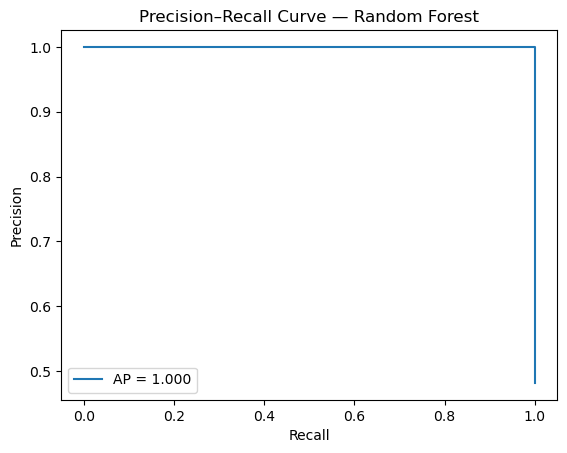

In [26]:

#Precision–Recall Curve 

prec_curve_rf, rec_curve_rf, _ = precision_recall_curve(y_test, y_score_rf, pos_label="p")

plt.figure()
plt.plot(rec_curve_rf, prec_curve_rf, label=f"AP = {ap_rf:.3f}")
plt.title("Precision–Recall Curve — Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
